# LoRA on MNIST  
This notebook will attempt to implement Low-Rank Adaptation(LoRA) Finetuning from scratch on the MNIST dataset using pytorch lightning. I'm purposely using a simple model and data that way I can focus on LoRA. 

Plan
1. Build an MLP. Train this model to perform well on MNIST 0-4 (half of the data).
3. Use standard finetuning approach to train this model to work on MNIST 5-9 (this will act as our baseline)
4. Use LoRA finetuning to train the original model to work on MNIST 5-9
5. Compare finetuning techniques (performance, memory etc)

Other ideas:
- LoRA from 1/2 of the dataset to the entire thing (replicates "change of data" a bit more)
- try to FT as "quickly as possible" (fewest epochs/steps)

Sources:
1. https://lightning.ai/pages/community/tutorial/lora-llm/ - (The first half offers useful starter pseudocode)
2. https://colab.research.google.com/drive/1iERDk94Jp0UErsPf7vXyPKeiM4ZJUQ-a?usp=sharing#scrollTo=WuK0lPwcB7Ia - had some good ideas on metrics to compute about LoRA-ized model
3. https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/mnist-hello-world.html - starter code for building an MLP and training on MNIST

In [1]:
# reserved for imports

import lightning as L
from lightning.pytorch.loggers import CSVLogger

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import MNIST
from torchvision import transforms

from torchmetrics import Accuracy

import pandas as pd
import seaborn as sn

In [2]:
# reserved for constants
PATH_DATASETS = '/home/sunil/lora_from_scratch/data'


# Step 1: Train an MLP on the first half of MNIST

In [3]:
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr

        # Hardcode some dataset specific attributes
        self.num_classes = 10 # this model will only be working on 1/2 of MNIST at any given time
        self.dims = (1, 28, 28) # the shape of an example (C x W x H)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 256

        
        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        # Define metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        x = self.model(x)

        # notice that we return the log probabilities here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)

    def common_step(self, batch, batch_idx):
        # define steps all of {train, val, test} will take in one place
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return logits, loss
        
        

    def training_step(self, batch, batch_idx):
        _, loss = self.common_step(batch, batch_idx)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        # we'll use adam for simplicity
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def prepare_data(self):
        # download data
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)


    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=16)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=16)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

        
        

        


In [4]:
model = LitMNIST()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Epoch 0: 100%|███████████████████████████████████████████████████████████████████| 215/215 [00:05<00:00, 38.54it/s, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████████████████████████████████| 215/215 [00:05<00:00, 37.87it/s, v_num=6, val_loss=0.427, val_acc=0.891]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████████████████████████████| 215/215 [00:05<00:00, 37.80it/s, v_num=6, val_loss=0.302, val_acc=0.913]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████████████████████████████████| 215/215 [00:05<00:00, 37.53it/s, v_num=6, val_loss=0.259, val_acc=0.923]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|████████████████████████████████████| 215/215 [00:05<00:00, 37.48it/s, v_num=6, val_loss=0.232, val_acc=0.930]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|████████████████████████████████████| 215/215 [00:05<00:00, 38.01it/s, v_num=6, val_loss=0.210, val_acc=0.937]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|████████████████████████████████████| 215/215 [00:

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████| 215/215 [00:06<00:00, 30.96it/s, v_num=6, val_loss=0.146, val_acc=0.954]


In [5]:
trainer.test()

/home/sunil/miniconda3/envs/lora_from_scratch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/lightning_logs/version_6/checkpoints/epoch=9-step=2150.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoin

Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9544000029563904     │
│         test_loss         │    0.14914950728416443    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.14914950728416443, 'test_acc': 0.9544000029563904}]

,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.427368,0.8906,NaN,NaN
1,0.301896,0.9128,NaN,NaN
2,0.259299,0.9234,NaN,NaN
3,0.231935,0.9302,NaN,NaN
4,0.209994,0.9370,NaN,NaN


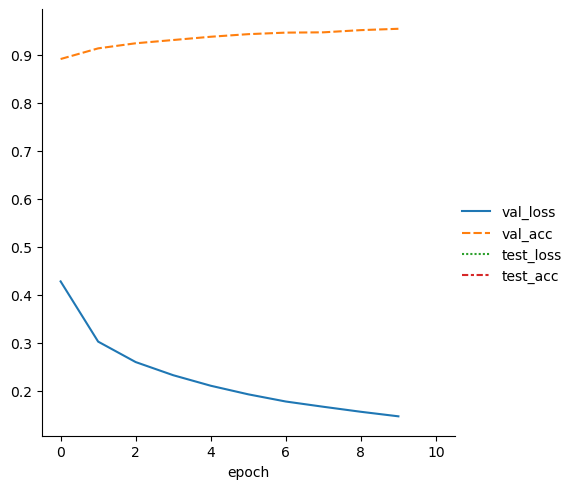

In [6]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")